## ●	機器學習 clustering MingHsun
### scikit learning 使用 clustering

## 各集群方法比較
● K-Means <br>
-給予一組資料，設定k值,將之分為k類。
1.隨機選取資料組中的k筆資料當作初始群中心
2.計算每個資i 對應到最短距離的群中心
3.用目前得到的分類重新計算群中心
4.重複step 2,3直到收斂 (ex:群心中移動距離很小)<br>
● AffinityPropagation<br>
-不用指定明確的具類數量
-算法複雜度高，通常要計算比較久
-在scikit中，重要是Preference和Damping factor這兩個參數，前者定了形成群聚的數量，值越大群聚数量越多(但不是指定)，Damping factor是作收斂(需再研究)。<br>
● MeanShift<br>
-不需要指定群聚數量
-是一種機率密度估計方法(類似kernel density)，所有點都會沿著梯度上升方向，收斂到它各自的最高峰。收斂到同一個高點為一個類，最終有多少個mode就有多少個類，所以不需要指定群聚個數。<br>
● SpectralClustering<br>
-用特徵來做分類，而不是依據距離之類的(就像是PCA)
-對誤差較不在乎，計算複雜度較小
-不適合群聚數量多的
-對於特殊形狀的、不規則的形狀比較好<br>
● Ward<br>
● AgglomerativeClustering<br>
-每個點都視為一個群集。接下來，則找出最相近的兩個群集，將其合併為一個新群集。重覆以上的合併動作，直到結束<br>
● DBSCAN (論文使用)<br>
-主要特熱DBSCAN能夠跨越邊界的限制，排除低密度的雜訊點位 (Noise Point) 以找處高密度的群集點位
-要搜尋半徑範圍 (Radius) 與形成核心群集的資料點數量門檻值 (Min-Points)<br>
● Birch<br>
-首先利用類似結構樹的結構進行劃分(CF樹)，然後再利用其它群聚方法對這些群聚進行優化

C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is n

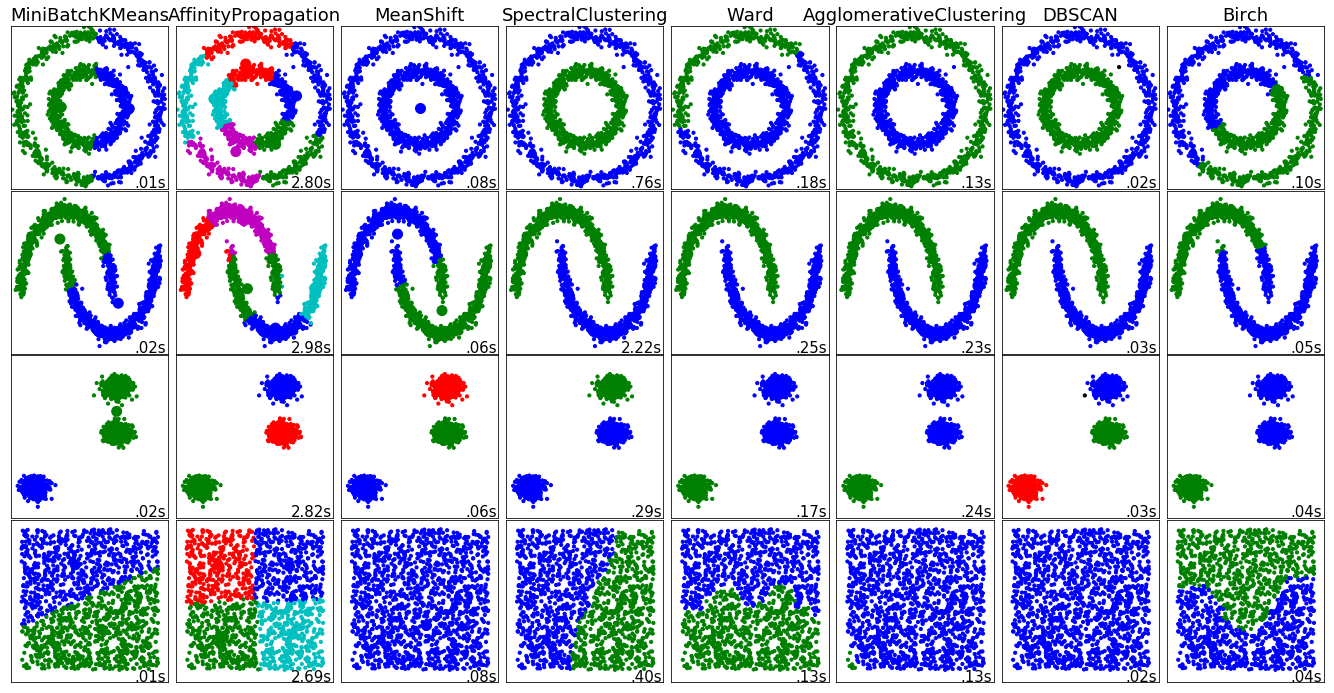

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=2)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# SpectralClustering 

C:\Users\Ming\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


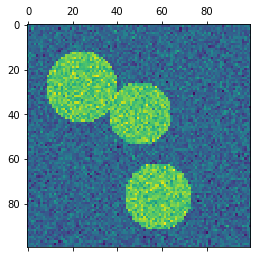

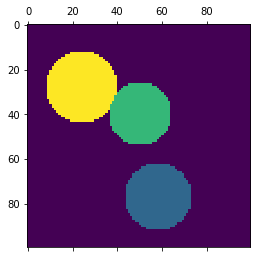

In [1]:
import numpy as np   
import matplotlib.pyplot as plt   
from sklearn.feature_extraction import image   
from sklearn.cluster import spectral_clustering   
  
# 使用np產生三個圓的影像
l = 100   
x, y = np.indices((l, l))   
  
center1 = (28, 24)   
center2 = (40, 50)   
center3 = (77, 58)   
  
radius1, radius2, radius3 = 16, 14, 15   
  
circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2   
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2   
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2   
   
img = circle1 + circle2 + circle3   
mask = img.astype(bool)   
img = img.astype(float)   
  
img += 1 + 0.2 * np.random.randn(*img.shape)   
graph = image.img_to_graph(img, mask=mask)   
graph.data = np.exp(-graph.data / graph.data.std())   
  
# 使用spectral_clustering進行聚類分析的結果
labels = spectral_clustering(graph, n_clusters=3)   
label_im = -np.ones(mask.shape)   
label_im[mask] = labels   
  
plt.matshow(img)   
plt.matshow(label_im)   
  
plt.show()   

In [ ]:
### Reference:http://www.dataivy.cn/blog/%E8%B0%B1%E8%81%9A%E7%B1%BBspectral-clustering/